In this exercise we will examine the spatial coverage and representativeness of a weather network by applying a circular buffer to each station, and then applying intersection, difference, and dissolve operations to identify the network's current reach but also to pinpoint critical gaps in coverage, which can be used by network managers to guide network expansion or optimization to ensure more uniform spatial representation.

In [130]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


## Define geographic and projected coordinate reference systems
A Coordinate Reference System (CRS) is a framework that defines how the two-dimensional, flat surface of a map relates to the real places on the three-dimensional surface of the Earth. CRSs ensure that locations are accurately represented in spatial analyses and visualizations. There are two primary types of CRSs: Geographic Coordinate Systems and Projected Coordinate Systems. 

Geographic Coordinate Systems use a three-dimensional spherical surface to define locations on the Earth. They express locations as latitude and longitude, which are angles measured from the Earth's center to a point on the Earth's surface. This system is great for global and regional mapping because it represents the Earth's curvature. 

On the other hand, Projected Coordinate Systems transform geographic coordinates into Cartesian coordinates (x and y values) on a flat surface. This projection process introduces some distortions, but it allows for more practical measurements and calculations in units like meters, making projected coordinates ideal for detailed local maps where accurate distances and areas are essential. Each PCS is designed for specific regions or purposes, minimizing distortions within its intended area of use. You will notice that computations of area and length, and even the determinatino of buffers in GeoPandas require changing the CRS from geographic to projected coordinates.


In [202]:
# Define projected and geographic coordinate reference systems
utm14 = 32614 # UTM Zone 14
wgs84 = 4326 # WGS84


## Read and inspect datasets

In [203]:
# Read stations
stations = gpd.read_file('../datasets/KS_mesonet_geoinfo.csv')
stations[['lon','lat']] = stations[['lon','lat']].astype('float')
stations['geometry'] = gpd.points_from_xy(x=stations['lon'], y=stations['lat'], crs=wgs84)


In [204]:
# Read counties map (only for visuals, not used in any core computation) (already in WGS84)
counties = gpd.read_file('../datasets/spatial/us_county_5m.geojson') #.to_crs(epsg_wgs)
idx_state = counties['STATE_NAME'] == 'Kansas'
counties = counties.loc[idx_state].reset_index(drop=True)


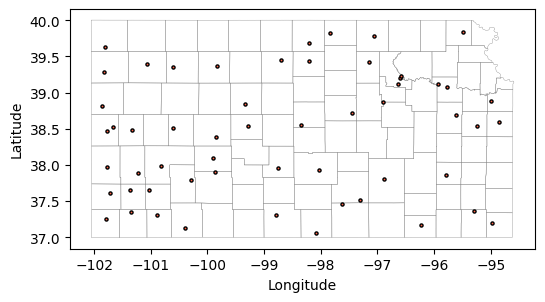

In [205]:
# Creaet figure using object-based syntax
fig, ax = plt.subplots(1, 1, figsize=(6,4))
counties.plot(ax=ax, facecolor='None', edgecolor='gray', linewidth=0.25)
stations.plot(ax=ax, facecolor='tomato', edgecolor='k', markersize=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Create buffer

We will assume that each weather station is representative of an area with a 50 km radius. While on a daily basis locations within this buffer area can exhibit weather differenes, overall climatic trends should be fairly consistent within this radius.

In [206]:
# Create a buffer
stations['buffer'] = stations.to_crs(utm14).buffer(50_000).to_crs(wgs84)

# Set buffer as geometry for easy plotting and analysis in posterior steps
stations.set_geometry('buffer', inplace=True)


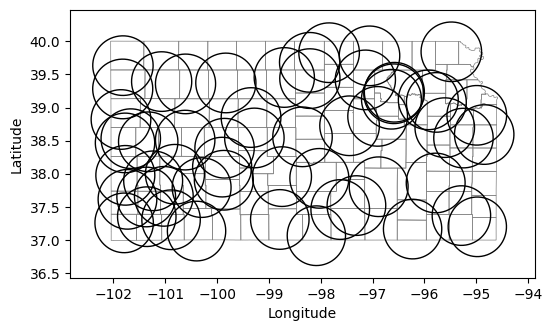

In [207]:
# Creaet figure using object-based syntax
fig, ax = plt.subplots(1, 1, figsize=(6,4))
counties.plot(ax=ax, facecolor='None', edgecolor='gray', linewidth=0.5)
stations.plot(ax=ax, facecolor='None', edgecolor='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Find area represented by the stations

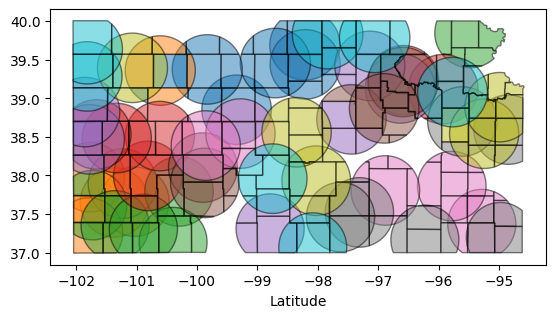

In [208]:
# Find represented areas of the state
represented_area = counties.overlay(stations, how='intersection')
represented_area.plot(alpha=0.5, edgecolor='k', cmap='tab10');
plt.xlabel('Longitude')
plt.xlabel('Latitude')
plt.show()

# Find area not represented by the stations

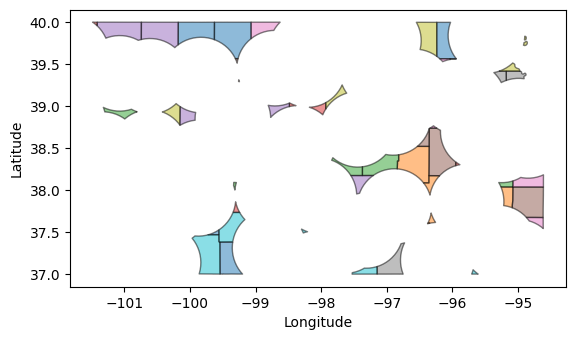

In [209]:
# Find non-represented county areas
non_represented_area = counties.overlay(stations, how='difference')
non_represented_area.plot(alpha=0.5, edgecolor='k', cmap='tab10');
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Dissolve polygons

Note that the previous polygons still retain the county boundaries. If we want to compute the area of each polygon, we first need to dissolve the internal boundaries. This operation will create a single `MultiPolygon` feature with all the polygons inside. To separate each polygon, we can use the `explode()` method.


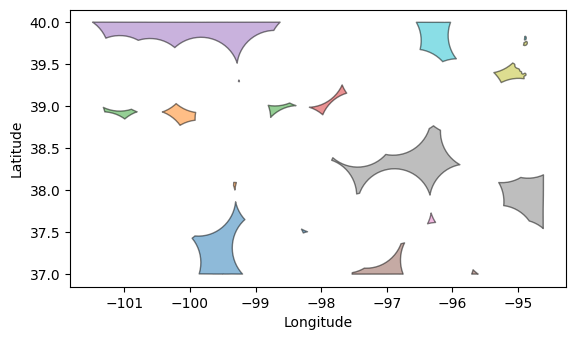

In [213]:
# Dissolve polygons
non_represented_area = non_represented_area.dissolve()
non_represented_area = non_represented_area.explode(index_parts=True).reset_index(drop=True)
non_represented_area.plot(alpha=0.5, edgecolor='k', cmap='tab10');
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Find largest polygon not covered by the network

In [214]:
# Find largest non-represented area
non_represented_area['area'] = non_represented_area.to_crs(utm14).area
non_represented_area['perimeter'] = non_represented_area.to_crs(utm14).length
idx_largest_area = non_represented_area['area'].argmax()
non_represented_area.head(3)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,area,perimeter,geometry
0,20,137,00485032,0500000US20137,20137,Norton,Norton County,KS,Kansas,06,2274122718,8421464,3.187139e+09,300298.876438,"POLYGON ((-99.37539 37.00018, -99.40702 36.999..."
1,20,137,00485032,0500000US20137,20137,Norton,Norton County,KS,Kansas,06,2274122718,8421464,1.542991e+07,21123.638265,"POLYGON ((-98.30280 37.53727, -98.29914 37.535..."
2,20,137,00485032,0500000US20137,20137,Norton,Norton County,KS,Kansas,06,2274122718,8421464,1.996688e+07,24035.816406,"POLYGON ((-99.30669 38.04489, -99.31468 38.001..."


## Display the largest area not represented by the network

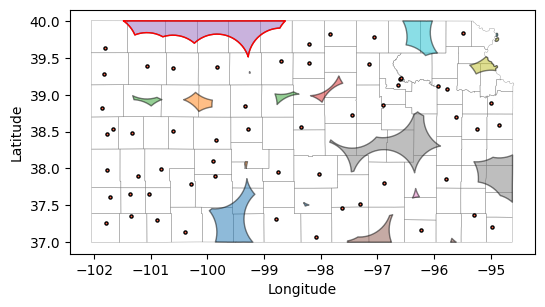

In [215]:
# Find non-represented county areas

# We need to restore geometry to points (not buffers)
stations.set_geometry('geometry',inplace=True)

# Creaet figure showing largest non-represented area
fig, ax = plt.subplots(1, 1, figsize=(6,4))
counties.plot(ax=ax, facecolor='None', edgecolor='gray', linewidth=0.25)
non_represented_area.plot(ax=ax, alpha=0.5, edgecolor='k', cmap='tab10');
stations.plot(ax=ax, facecolor='tomato', edgecolor='k', markersize=5)
non_represented_area.loc[[idx_largest_area],'geometry'].plot(ax=ax, facecolor='None',edgecolor='red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



## Practice

- How do the non-represented areas change in shape and size when changing the buffer radius from 50 km to 10 km?

- Using the `area` and `perimeter` of the polygons representing areas without station coverage, compute additional metrics to identify larger polygons with different shape properties. One option is to use the Shape Index, $SI = \frac{Perimeter}{\sqrt{Area}}$, which decreases as the area increases, for a given perimeter. This makes it a suitable metric for identifying large polygons without being overly penalized for having a larger perimeter.
